In [7]:


import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta, AutoNormal
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete, Trace_ELBO
import torch

import seaborn as sns
import matplotlib.pyplot as plt



# Model

Below is a simple 1D gaussian mixture model with component specific means and global variance parameters.  We have used the @config_enumerate decorator to tell pyro to enumerate over, or marginalize, the discrete random variables (assignment).


In [8]:

K = 2

@config_enumerate
def model(data=None, n_data=None):
    assert (data is None) != (n_data is None)
    if n_data is None:
        n_data = data.shape[0]

    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
    scale = pyro.sample('scale', dist.LogNormal(0., 0.5))

    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(0., 4.))

    with pyro.plate('data', n_data):
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample('obs', dist.Normal(locs[assignment], scale), obs=data)



# Simulate data

Generate 100 data points from the model.  Print the simulated parameters and show a histogram of the simulated data.


weights [0.917575   0.08242498]
scale 0.3148601
locs [6.5407276 8.245778 ]


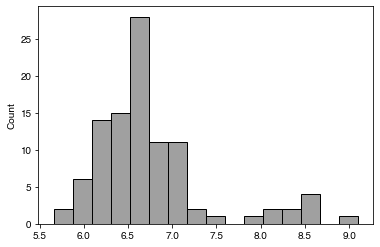

In [9]:

pyro.set_rng_seed(2022)
pyro.clear_param_store()

model_trace = pyro.poutine.trace(model)

samples = model_trace.get_trace(n_data=100)

for a in ('weights', 'scale', 'locs'):
    print(a, samples.nodes[a]['value'].detach().numpy())

sns.histplot(x=samples.nodes['obs']['value'].detach().numpy(), color='0.5')

data = samples.nodes['obs']['value'].detach()



# Inference

Use the TraceEnum_ELBO implementation of the elbo calculation that enumerates and marginalizes over the discrete hidden variables.  Use the AutoDelta guide for the remaining variables, which will use a delta function to approximate the posteriors of hidden variables producing point estimates of each variable.


In [10]:

optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

pyro.set_rng_seed(1)
pyro.clear_param_store()

global_guide = AutoDelta(
    pyro.poutine.block(model, expose=['weights', 'locs', 'scale']))

svi = SVI(model, global_guide, optim, loss=elbo)



...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................

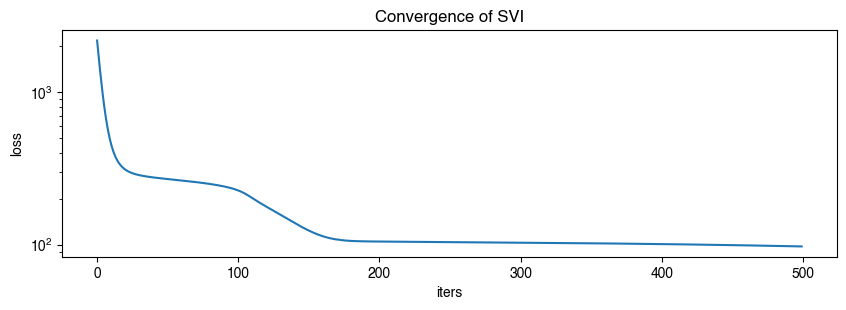

In [11]:

losses = []
for i in range(500):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')

plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI');


In [12]:

for k in pyro.get_param_store():
    print(k, pyro.get_param_store()[k].detach())


AutoDelta.weights tensor([1.0000e+00, 1.3988e-09])
AutoDelta.scale tensor(0.6579)
AutoDelta.locs tensor([6.7522, 4.4876])



# Additional exercises

1. The inferred parameters were innaccurate, try generating a better initialization as described in the [gmm tutorial](https://pyro.ai/examples/gmm.html#Training-a-MAP-estimator)
2. Extend the GMM to a 2D model
3. Modify from global variance to component specific variance
4. Modify from global variance to dimension specific variance
